In [4]:

import sys
sys.path.insert(0, "FA_IR")
import pandas as pd
from pandas.io.json import json_normalize  
import os, sys
import argparse
import pickle
import numpy as np
from FA_IR.post_processing_methods.fair_ranker.create import feldmanRanking
from FA_IR.post_processing_methods.fair_ranker.test import FairnessInRankingsTester
from FA_IR.utilsAndConstants.constants import ESSENTIALLY_ZERO
from FA_IR.utilsAndConstants.utils import setMemoryLimit
from dataset_creator import *

import numpy as np
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random as random

from calibration_util import *
from kendall_errors import *
%matplotlib inline

In [5]:
def writePickleToDisk(data, filename):
    with open(filename, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
def loadPickleFromDisk(filename):
    with open(filename, 'rb') as handle:
        data = pickle.load(handle)
    return data

In [7]:
def convertFormat(inpath, outpath, filename):
    df = pd.DataFrame([ [x.qualification, x.originalQualification, x.isProtected] for x in loadPickleFromDisk(inpath+filename)], columns=['y_pred','y','g'])
    df.to_pickle(outpath+filename)

In [8]:
def flairRanking(k, protectedCandidates, nonProtectedCandidates, minProp, alpha):

    result = []
    gft = FairnessInRankingsTester(minProp, alpha, k, correctedAlpha=True)
    countProtected = 0

    idxProtected = 0
    idxNonProtected = 0

    for i in range(k):
        if idxProtected >= len(protectedCandidates) and idxNonProtected >= len(nonProtectedCandidates):
            # no more candidates available, return list shorter than k
            return result, []
        if idxProtected >= len(protectedCandidates):
            # no more protected candidates available, take non-protected instead
            result.append(nonProtectedCandidates[idxNonProtected])
            idxNonProtected += 1

        elif idxNonProtected >= len(nonProtectedCandidates):
            # no more non-protected candidates available, take protected instead
            result.append(protectedCandidates[idxProtected])
            idxProtected += 1
            countProtected += 1

        elif countProtected < gft.candidates_needed[i]:
            # add a protected candidate
            result.append(protectedCandidates[idxProtected])
            idxProtected += 1
            countProtected += 1

        else:
            # find the best candidate available
            if protectedCandidates[idxProtected].qualification >= nonProtectedCandidates[idxNonProtected].qualification:
                # the best is a protected one
                result.append(protectedCandidates[idxProtected])
                idxProtected += 1
                countProtected += 1
            else:
                # the best is a non-protected one
                result.append(nonProtectedCandidates[idxNonProtected])
                idxNonProtected += 1

    return result, __mergeTwoRankings(protectedCandidates[idxProtected:], nonProtectedCandidates[idxNonProtected:])


In [9]:
def __mergeTwoRankings(ranking1, ranking2):
    result = ranking1 + ranking2
    result.sort(key=lambda candidate: candidate.originalQualification, reverse=True)
    return result

In [17]:
def rankFixedPropVaryK(protected, nonProtected, pAndAlpha, prefs):

    for k in prefs:
        res ={}
        res[k] = {}
        print("colorblind ranking", end='', flush=True)
        cb =  flairRanking(k, protected, nonProtected, ESSENTIALLY_ZERO, 0.1)[0]
        res[k]['cb'] = pd.DataFrame([ [x.qualification, x.originalQualification, x.isProtected] 
                                              for x in cb], columns=['y_pred','y','g'])
        print(" [Done]")

        print("fair rankings", end='', flush=True)
        fair =  flairRanking(k, protected, nonProtected, pAndAlpha[0], pAndAlpha[1])[0]
        res[k]['fair'] = pd.DataFrame([ [x.qualification, x.originalQualification, x.isProtected] 
                                              for x in fair], columns=['y_pred','y','g'])
        print(" [Done]")

        print("feldman ranking", end='', flush=True)
        feld = feldmanRanking(protected, nonProtected, k)[0]
        res[k]['feld'] = pd.DataFrame([ [x.qualification, x.originalQualification, x.isProtected] 
                                              for x in feld], columns=['y_pred','y','g'])
        print(" [Done]")
        return res

In [18]:
def plot_all(data, w, s): 
    plt.figure(figsize=(12, 3,))
    plt.subplot(131) # equivalent to: plt.subplot(2, 2, 1)
    
    e0,e1 = sliding_kendall_parity(data, window=w, step=s)
    plt.plot(e0, color='red')
    plt.plot(e1, color='blue')
    plt.ylim([0,1])
    plt.title("Parity")

    plt.subplot(132) # equivalent to: plt.subplot(2, 2, 1)
    e0,e1 = sliding_kendall_cal2(data, window=w, step=s)
    plt.plot(e0, color='red')
    plt.plot(e1, color='blue')
    plt.ylim([0,1])
    plt.title("Calibration")

    plt.subplot(133) # equivalent to: plt.subplot(2, 2, 1)
    e0,e1 = sliding_kendall_eq(data, window=w, step=s)
    plt.ylim([0,1])
    plt.plot(e0, color='red')
    plt.plot(e1, color='blue')
    plt.title("Equality")
    plt.show()

In [19]:
#German Credit
#vary length of prefix, keeping prop fixed
prefs = [100, 150, 200, 250, 300, 350, 400, 450, 500]
pairsOfPAndAlpha = (0.4, 0.0222)

protectedGermanCreditAge25, nonProtectedGermanCreditAge25 = germanCreditData.create(
        "FA_IR/rawData/GermanCredit/GermanCredit_age25.csv", "DurationMonth", "CreditAmount",
        "score", "age25", protectedAttribute=["younger25"])

prop40 = rankFixedPropVaryK(protectedGermanCreditAge25, nonProtectedGermanCreditAge25,
        pairsOfPAndAlpha, prefs)

colorblind ranking [Done]
fair rankings [Done]
feldman ranking [Done]


In [24]:
prop40[100]['cb'].head()

,y_pred,y,g
0,0.790280,0.790280,False
1,0.761418,0.761418,False
2,0.744449,0.744449,False
3,0.731606,0.731606,False
4,0.723021,0.723021,False



cb
# protected items 9
# protected items 91


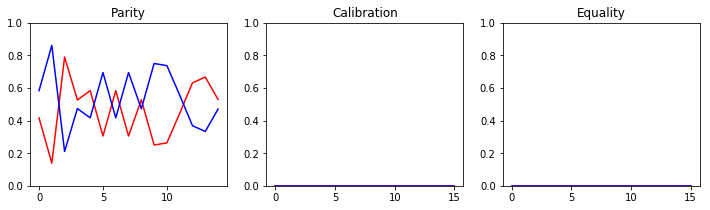

        parity  cal   eq
trend0    0.09  0.0  0.0
trend1   -0.09  0.0  0.0
dist      0.30  0.0  0.0

feld
# protected items 15
# protected items 85


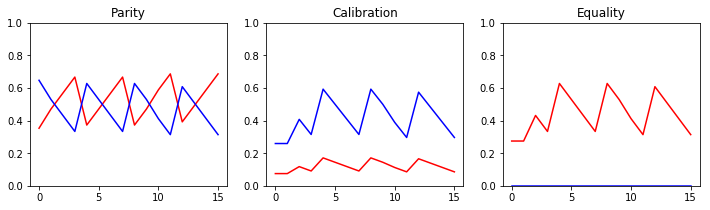

        parity   cal    eq
trend0    0.13  0.02  0.08
trend1   -0.13  0.08  0.00
dist      0.20  0.29  0.44

fair
# protected items 30
# protected items 70


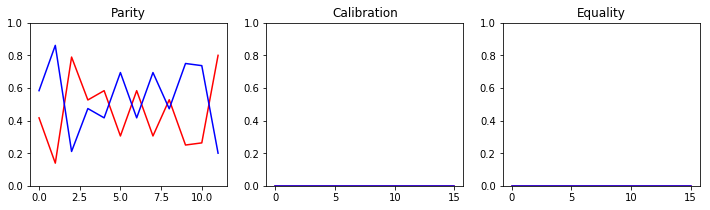

        parity  cal   eq
trend0    0.04  0.0  0.0
trend1   -0.04  0.0  0.0
dist      0.36  0.0  0.0


In [34]:
w = 20
s =5
for k in prop40:
    for t in ['cb','feld','fair']:
        print("\n"+t)
        cb = prop40[k][t]
        print("# protected items", len(cb[cb['g']==True]))
        print("# protected items", len(cb[cb['g']==False]))
        plot_all(cb, w, s)
        print(diagnose_k(cb, w, s).round(2))